In [69]:
import torch as t
import numpy as np
from torch import nn
import createdFuncs as past
import fancy_einsum as einsum
import einops
import pandas as pd


# Multihead Attention Block

First, I need to change the masked attention block to work over multiple batches. As I'm working through this, I'm reminded that I really need to understand einops and linear algebra. The matrix multiplication really feels like a black box operation!

In [70]:
def single_head_masked_attention(Q: t.Tensor, K: t.Tensor, V: t.Tensor) -> t.Tensor:
    '''
    Should return the results of masked self-attention.

    See "The Decoder Side" section of the Illustrated Transformer for an explanation of masking.

    Q: shape (batch, seq_len, head_size)
    K: shape (batch, seq_len, head_size)
    V: shape (batch, seq_len, value_size)

    Return: shape (batch, seq_len, value_size)
    '''
    # second step - calculate a "score"
    newK = einsum.einsum('b s h -> b h s', K)
    score = Q@newK
    # third step - divide score by dimensionality
    score = score / np.sqrt(Q.shape[-1])
    print(score.shape)
    # MASKING IN BETWEEN!
    mask = t.ones(score.shape)
    for batch, submask in enumerate(mask):
        for i, x in enumerate(submask):
            x[i+1:] = -t.inf

    score = score * mask
    # fourth step - softmax
    score = nn.functional.softmax(score, dim=-1)

    # fifth step - multiply each value vector by the softmax score
    z = score@V
    return z

In [71]:
# testing the new block
# personal mini-test to see if its working correctly
Q = t.tensor([[[1],[3],[4]],[[1],[3],[4]]],dtype=float)
K = t.tensor([[[1],[3],[4]],[[1],[3],[4]]],dtype=float)
V = t.tensor([[[1],[3],[4]],[[1],[3],[4]]],dtype=float)

print(single_head_masked_attention(Q,K,V))

torch.Size([2, 3, 3])
tensor([[[1.0000],
         [2.9951],
         [3.9820]],

        [[1.0000],
         [2.9951],
         [3.9820]]], dtype=torch.float64)


Here's the multiheaaded attention block!

*(Cody on Saturday here: this one does not work fully as intended! I have reimplemented it below, look at it below!)*

In [72]:
# this is bad! do not use it!
# this is bad! do not use it!
# this is bad! do not use it!

def multihead_masked_attention(Q: t.Tensor, K: t.Tensor, V: t.Tensor, num_heads: int):
    '''
    Implements multihead masked attention on the matrices Q, K and V.

    Q: shape (batch, seq, nheads*head_size)
    K: shape (batch, seq, nheads*head_size)
    V: shape (batch, seq, nheads*head_size)
    '''
    # reshape Q, K, and V into 4D tensors to isolate the different heads
    batch, seq, product = Q.shape
    head_size = product // num_heads
    Q = Q.reshape((batch, seq, num_heads, head_size))
    K = K.reshape((batch, seq, num_heads, head_size))
    V = V.reshape((batch, seq, num_heads, head_size))

    # calculate attention scores
    newK = einsum.einsum('b s n h -> b h n s', K)
    score = einsum.einsum('b s n h, b h n a -> b s n a', Q, newK)
    # third step - divide score by dimensionality
    score = score / np.sqrt(Q.shape[-1])
    # MASKING IN BETWEEN!
    mask = t.ones(score.shape)
    for _, batchMask in enumerate(mask):
        for i, seqMask in enumerate(batchMask):
            for j, x in enumerate(seqMask):
                x[i+1:] = -t.inf 

    score = score * mask
    # fourth step - softmax
    score = nn.functional.softmax(score, dim=-1)
    print(score.shape)
    print(V.shape)
    # fifth step - multiply each value vector by the softmax score
    z = einsum.einsum('b s n s, b s n h -> b s n h ', score, V)
    z = z.reshape((batch, seq, product))
    return z

In [73]:
# test from James Dao; my stuff continues to work
Q = t.linspace(0, 10, 2 * 5 * 4).reshape(2, 5, 4)
K = t.linspace(5, 20, 2 * 5 * 4).reshape(2, 5, 4)
V = t.linspace(15, 2, 2 * 5 * 4).reshape(2, 5, 4)
multihead_masked_attention(Q, K, V, num_heads=2)

torch.Size([2, 5, 2, 5])
torch.Size([2, 5, 2, 2])


tensor([[[15.0000, 14.6667, 14.3333, 14.0000],
         [12.6399, 12.3316, 12.6629, 12.3383],
         [12.2258, 11.8953, 11.6333, 11.3009],
         [10.9897, 10.6567, 10.3302,  9.9969],
         [ 9.6657,  9.3324,  8.9997,  8.6664]],

        [[ 8.3333,  8.0000,  7.6667,  7.3333],
         [ 7.0000,  6.6667,  6.3333,  6.0000],
         [ 5.6667,  5.3333,  5.0000,  4.6667],
         [ 4.3333,  4.0000,  3.6667,  3.3333],
         [ 3.0000,  2.6667,  2.3333,  2.0000]]])

Making an attention block out of the above function is tricky. May need to come back to it after re-reading some more transformer stuff. For now, I'll go and review einsum :)

And... after reviewing, and feeling better, about einsum, I'll need to call it a day.

Saturday, October 30 - it's been a bit since I've worked on this, and I really need to understand multi-headed attention. But, I don't think I really do, yet, so I'm going to try to write out the previous function again :)

In [74]:
def multihead_masked_attention(Q: t.Tensor, K: t.Tensor, V: t.Tensor, num_heads: int):
    '''
    Implements multihead masked attention on the matrices Q, K and V.

    Q: shape (batch, seq_len, nheads*headsize)
    K: shape (batch, seq_len, nheads*headsize)
    V: shape (batch, seq_len, nheads*headsize)
    '''
    
    Q = einops.rearrange(Q, 'b s (n h) -> b n s h', n = num_heads)
    K = einops.rearrange(K, 'b s (n h) -> b n s h', n = num_heads)
    V = einops.rearrange(V, 'b s (n h) -> b n s h', n = num_heads)


    scores = einsum.einsum('b n k h, b n s h -> b n s k', K, Q)
    assert scores.shape == t.Size([Q.shape[0], num_heads,Q.shape[2], K.shape[2]])

    scores = scores / np.sqrt(Q.shape[-1])
    attention = scores + t.triu(t.ones_like(scores) * float("-inf"), diagonal=1) # THIS IS STOLEN FROM JAY - testing it out
    softed = t.softmax(attention,dim=-1)
    result =  einsum.einsum('batch numheads seqQ seqK, batch numheads seqK headsize -> batch numheads seqQ headsize',softed, V)
    return einops.rearrange(result, 'batch numheads seqQ headsize -> batch seqQ (numheads headsize)')

In [75]:
# test from James Dao; my stuff continues to work
Q = t.linspace(0, 10, 2 * 5 * 4).reshape(2, 5, 4)
K = t.linspace(5, 20, 2 * 5 * 4).reshape(2, 5, 4)
V = t.linspace(15, 2, 2 * 5 * 4).reshape(2, 5, 4)
multihead_masked_attention(Q, K, V, num_heads=2)

tensor([[[15.0000, 14.6667, 14.3333, 14.0000],
         [13.7668, 13.4335, 13.0346, 12.7012],
         [12.3451, 12.0117, 11.6705, 11.3372],
         [11.0013, 10.6679, 10.3337, 10.0004],
         [ 9.6668,  9.3335,  9.0000,  8.6667]],

        [[ 8.3333,  8.0000,  7.6667,  7.3333],
         [ 7.0000,  6.6667,  6.3333,  6.0000],
         [ 5.6667,  5.3333,  5.0000,  4.6667],
         [ 4.3333,  4.0000,  3.6667,  3.3333],
         [ 3.0000,  2.6667,  2.3333,  2.0000]]])

In [76]:
class MultiheadMaskedAttention(nn.Module):
    W_QKV: nn.Linear
    W_O: nn.Linear

    def __init__(self, hidden_size: int, num_heads: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        self.WQKV = t.nn.Linear(self.hidden_size, 3 * hidden_size) # TODO: why do we use a linear layer here? aren't they matricies?
        self.W0 = t.nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, seq, hidden_size)

        Return: shape (batch, seq, hidden_size)
        '''
        #print("YO?")
        x = x.float() # seems like it needs to be a float!
        QKV = self.WQKV(x)
        Q = QKV[:,:,:self.hidden_size]
        K = QKV[:,:,self.hidden_size:self.hidden_size * 2]
        V = QKV[:,:,self.hidden_size * 2:]
        assert Q.shape == K.shape == V.shape == x.shape
        return self.W0(multihead_masked_attention(Q,K,V,self.num_heads))

In [77]:
t.manual_seed(420)
m = MultiheadMaskedAttention(6, 2)
x = t.linspace(0, 42, 2 * 3 * 6).reshape(2, 3, 6)
m(x)

tensor([[[ -0.7193,   0.4614,   0.4117,  -0.5813,   0.2754,  -0.5745],
         [ -0.7746,   0.6206,   0.5520,  -0.7370,   0.1787,  -0.7289],
         [ -1.1632,   1.7392,   1.5775,  -1.7907,  -0.5079,  -1.8103]],

        [[  0.0549,  -1.9665, -10.8756,  -7.1792,   3.4559,   0.9521],
         [ -0.3971,  -0.6652,  -9.6883,  -8.4108,   2.6582,  -0.3063],
         [ -0.8686,   0.6920,  -8.4500,  -9.6953,   1.8262,  -1.6189]]],
       grad_fn=<ViewBackward0>)

## Putting it All Together

In [78]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TransformerConfig:
    '''Constants used throughout your decoder-only transformer model.'''

    num_layers: int
    num_heads: int
    vocab_size: int
    hidden_size: int
    max_seq_len: int
    dropout: float = 0.1
    layer_norm_epsilon: float = 1e-05

partly copy-pasting - but FIXING -  the positional encoding from previous exercise

In [79]:
# from yesterday
class PositionalEncoding(nn.Module):

    def __init__(self, embedding_dim: int, max_seq_len: int = 5000):
        super().__init__()
        self.dim = embedding_dim
        self.length = max_seq_len

        # mostly copied. i understand this, just need to work on 
        # making more tensors and getting more exposure to methods of making tensors
        def P (delta):
            n = 10000 # hardcoded
            d = embedding_dim
            l = max_seq_len
            sin_array = np.sin(delta / n ** (2 * np.arange(d//2) / d))
            cos_array = np.cos(delta / n ** (2 * np.arange(d//2) / d))

            array = np.zeros(d)
            array[::2] = sin_array
            array[1::2] = cos_array

            return array

        tokenArray = []
        for i in range(max_seq_len):
            tokenArray.append(P(i)) # changed from previous design
        
        self.multMax = t.tensor(np.array(tokenArray), dtype=float)
        

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, seq_len, embedding_dim)
        '''
        return x + self.multMax[:x.shape[1]]


In [80]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.layers = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size * 4),
            nn.GELU(),
            nn.Linear(self.hidden_size * 4, self.hidden_size),
            nn.Dropout(config.dropout)
        )
    def forward(self, x: t.Tensor):
        x = x.float() # seems like it needs to be a float!
        return self.layers(x).float() # ima do the same thing again!


In [81]:
class DecoderBlock(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.attentionBlock = nn.Sequential(
            MultiheadMaskedAttention(config.hidden_size,  config.num_heads),
            nn.LayerNorm(config.hidden_size)
        )
        self.MLP = nn.Sequential(
            MLP(config),
            nn.LayerNorm(config.hidden_size)
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        partOne = x + self.attentionBlock(x)
        return (partOne + self.MLP(partOne)).float() # seems like it needs to be a float!
        

In [82]:
class DecoderOnlyTransformer(nn.Module):

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.tokenize = nn.Embedding(config.vocab_size, config.hidden_size)
        self.positionize = PositionalEncoding(config.hidden_size,config.max_seq_len)
        self.restModel = nn.Sequential(
            nn.Dropout(config.dropout),
            *[DecoderBlock(config) for i in range(config.num_layers)],
            nn.LayerNorm(config.hidden_size),
        )
        self.unembed = self.tokenize.weight.T
        
    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.tokenize(x)
        x = self.positionize(x)
        toUnembed = self.restModel(x)
        return toUnembed@self.unembed

## Testing our model!

In [83]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

class CustomTextDataset(Dataset):
    def __init__(self,seq_len, total_size):
        self.seq_len = seq_len
        self.total_size = total_size
    
    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        input = t.randint(0,10,(self.seq_len,))
        target = t.flip(input,dims=(0,))
        return (input, target) 


In [84]:
thisConfig = TransformerConfig(
    num_layers = 2,
    num_heads = 8,
    vocab_size = 10,
    hidden_size = 40, # recall that this = num_heads * headsize
    max_seq_len = 10,
    dropout = 0.1,
    layer_norm_epsilon=0.00001
)

In [85]:
trainset = CustomTextDataset(8,1000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [86]:
trainloader.dataset[3]

(tensor([5, 0, 4, 6, 0, 7, 1, 9]), tensor([9, 1, 7, 0, 6, 4, 0, 5]))

In [87]:
myTransformer = DecoderOnlyTransformer(thisConfig)
optimizer = t.optim.Adam(myTransformer.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [88]:
# Test the model on the first few datapoints
myTransformer.eval()
for i in range(1):
    with t.no_grad():
        input, target = trainset[i]
        newInput = input[None, :] # TODO: this is so bad please i need to fix this bruh
        output = myTransformer(newInput).argmax(dim=-1)
        print(input, output, target)

tensor([0, 0, 5, 3, 5, 1, 2, 5]) tensor([[4, 4, 5, 3, 5, 1, 2, 5]]) tensor([5, 2, 1, 5, 3, 5, 0, 0])


In [89]:
# playing around with how to modify the targets to be able to use it in the criterion
for inputs, targets in trainloader:
    print(targets[0])
    print(t.nn.functional.one_hot(targets[0], num_classes=10)) # yeah, so the loss has gotta be one-hot-encoded!
    break

tensor([3, 9, 1, 0, 5, 4, 4, 5])
tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


In [90]:
NUM_EPOCHS = 120

losses = []
myTransformer.train()
for epoch in range(1, NUM_EPOCHS + 1):
    for inputs, targets in trainloader:
        outputs = myTransformer(inputs)
        targets = t.nn.functional.one_hot(targets, num_classes=10).float()
        outputs = einops.rearrange(outputs, 'batch seq vocab -> (batch seq) vocab')
        targets = einops.rearrange(targets, 'batch seq vocab -> (batch seq) vocab')

        loss = criterion(outputs,targets)

        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

<AxesSubplot: >

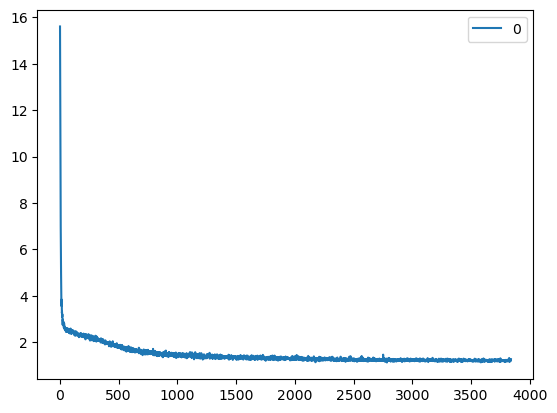

In [91]:
df = pd.DataFrame(losses)
df.plot()

In [93]:
myTransformer.eval()
# testing it out
for inputs, targets in trainloader:
    input = inputs[0]
    input = input[None, :]
    print(input)
    
    print(myTransformer(input).argmax(dim=-1))
    break

tensor([[2, 9, 4, 0, 6, 5, 3, 1]])
tensor([[1, 0, 2, 2, 0, 4, 9, 2]])


# Retrospective:

Seeing this - albeit basic - transformer actually reverse the numbers is VERY MUCH satisfying. My implementation of the transformer is very iffy, I threw down a bunch of bandaid fixes at different parts, but it *works*, and that feels unbelievably amazing. 

The way the transformer still feels a bit abstract to me. Perhaps this is normal, maybe it's not. I can audibly describe the high-level ideas of how keys, queries, and values come together with attentioin, as well as other MLPs and Decoder Blocks, but it hasn't really... clicked, yet. I don't know if it clicks for most people, this architecture just seems too massive to really internalize. Also, I blame my poor understanding of Linear Algebra, that probably isn't helping, either.

Simply making this has taught me a lot about the difficulties of AI technical work in general, and is making me update upwards on the skill ceiling of alignment work. This exercise has been the hardest by a large margin, and I've tackled it for multiple days straight. Theres times where everything just feels overwhelming and my brain crashes, and those suck. But I think with practice, I'll get better at understanding these architectures, and not feeling too overwhelmed.